<h2> DATA CAMP REPORT </h2>
by Zhao ZHANG

<h2> Introduction </h2>


<p>The goal of this project is to develop prediction models able to <b>identify and quantify chemotherapeutic agents from their Raman spectra</b>.  


Part of these data are saved in the file <code>train.csv</code> as follows (<code>n_samples</code> being the number of samples): 
<ul>
    <li><b>molecule</b>: Type of chemotherapeutic agent. Six possible values: A for infliximab, B for bévacizumab, Q for ramucirumab, R for rituximab. Dimension: (<code>n_samples</code>,)</li>
    <li><b>vial</b>: Vial type. Three possible values: 1, 2, 3. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>solute</b>: Solute group. Fourteen possible values: 1, 2, ..., 14. Dimension: (<code>1</code>, <code>n_samples</code>)</li>
    <li><b>concentration</b>: Concentration of the molecule. Dimension: (<code>n_samples</code>, <code>1</code>)</li>
    <li><b>spectra</b>: Intensity of Raman spectrum. Dimension: (<code>n_samples</code>, <code>1866</code>)</li>
</ul>

<p>To sum up, there are two objectives:

<ul>
    <li><b>classification</b>: predict which molecule it corresponds to given the spectrum.</li>
    <li><b>regression</b>: predict the concentration of a molecule. The prediction should not depend on the vial or the solute group. The error metric is the mean absolute relative error (mare): $$\frac{1}{n_{samples}}\sum_{i=1}^{n_{samples}}\left|\frac{y_i-\hat{y}_i}{y_i}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.</li>
</ul>

## Exploratory data analysis

### Loading the data

In [2]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('train.csv')
y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [9]:
print X_df.head(1

   solute                                            spectra  vial
0      11  [0.0152963, 0.0152944, 0.0153142, 0.0154096, 0...     1
1       1  [0.0143634, 0.0143292, 0.0143999, 0.0145162, 0...     1
2       3  [0.0163027, 0.0161848, 0.0163573, 0.0164119, 0...     1
3      10  [0.0135833, 0.0135537, 0.0134438, 0.0136424, 0...     2
4       2  [0.020811, 0.020767, 0.0208674, 0.0207018, 0.0...     3
5       4  [0.0273853, 0.0271442, 0.0273076, 0.0272756, 0...     1
6       5  [0.016065, 0.0161625, 0.0161815, 0.0162885, 0....     3
7       9  [0.0225653, 0.0226097, 0.0222985, 0.0224744, 0...     2
8       1  [0.0145261, 0.014045, 0.0144388, 0.0143233, 0....     3
9       1  [0.0139963, 0.0143121, 0.0143192, 0.0140011, 0...     3


Number of samples: 999


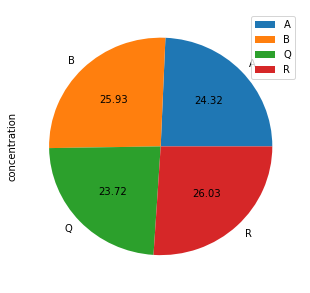

In [3]:
# Types of molecules
np.unique(y_df['molecule'].values)
print('Number of samples: %s' % len(y_df))
y_df.groupby('molecule').count().plot(y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

### Feature extractor for classification

For this part, I just added a function of preprocessing. For some classifications, the normalization of data should be necessary and it also make some progress. I tried several methods, but it returned worse result, such as Kbest.

In [4]:
import numpy as np
# import pandas as pd
from sklearn import preprocessing
class FeatureExtractorClf():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        # Normalise the data
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        XX = preprocessing.normalize(XX)
        return XX

### Classification: predicting the molecule type

In my code, every model should added a function PCA. Because 1866 features are too many for only 999 sample, so after PCA, it will reture n_components most important features. It really improves the performance. 

Firstly, I added a function XGBClassifier following the RandomForestClassifier, because the RandomForestClassifier contains a function of transforma. So, after the feature selection by PCA, the RandomForestClassifier transforms the selected features and it will be the input of the XGBClassifier. It did decease the error rate(from 0.1 to 0.08). But I found that most of Classifier are not runable as this form.

Secondly, I added several classifiers (ExtraTreesClassifier, SVM, KNN,XGBClassifier)
and I tried to merge these 4 classifiers. In my second submission, I gave weight to every prediction just like voting. And it got a better result(0.043 error rate). In fact, I spended so much time for calculating the weights for voting, but actually, after cross-validation, it means nothing. 

Thirdly, because I spended so long time to modify the weights and the parameters and it didn't work, I tried to find some other superior methods. I tried to use Bagging, because of some problems of the package, I could not use XGBClassifier as the base_estimator of Bagging(I don't kown why, but my friend can run my Bagging code in his computer). So, I choosen the ExtraTreesClassifier as my base_estimator. And fortunately, it returned a better result. I decided to reserve it.

Finally, the result is also far from the leader, I tried Stacking. The predictions of (ExtraTreesClassifier, SVM, KNN, XGBC) could be the features and I combined these predictions with X as new features, and I use the Bagging to fit them. The last three methods, they all have distancies of error rate between 2-fold. But this mothod make it more similary. Finally, I got about 0.04 of error rate. 

In [5]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import numpy as np
class Classifier(BaseEstimator):
    def __init__(self):
        
        self.n_components = 40
        self.n_estimators = 300
        self.clf1 = Pipeline([
            ('pca', PCA(n_components=self.n_components)),
  
            ('clf', RandomForestClassifier(n_estimators=self.n_estimators, random_state=42)),
            ('XGB', XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.05,nthread = 1))
        ])
        self.clf2 = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('et',ExtraTreesClassifier(n_jobs=4, n_estimators=2000, max_features=20, min_samples_split=3,
bootstrap=False, verbose=0, random_state=23))
            ])
        self.clf3 = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('svm', SVC(probability=True,C = 1e7))
            ])
        self.clf4 = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('bag', BaggingClassifier(base_estimator=self.clf2, n_estimators=5,
                                     max_samples=1.,random_state=23))
            ]) 
        self.clf5 = Pipeline([
                ('pca', PCA(n_components=self.n_components)),
                ('KNN', KNeighborsClassifier(6))
            ]) 
    def fit(self, X, y):
        self.clf1.fit(X, y)
        self.clf2.fit(X, y)
        self.clf3.fit(X,y)
        self.clf5.fit(X,y)
        #fit 4 classifiers and calulate the prediction based on X
        proba1 = self.clf1.predict_proba(X)
        proba2 = self.clf2.predict_proba(X)
        proba3 = self.clf3.predict_proba(X)
        proba5 = self.clf5.predict_proba(X)
        # Combination of the predictions and X as the new features
        proba = np.concatenate((proba1,proba2,proba3,proba5,X),axis = 1)
        #fit them with bagging
        self.clf4.fit(proba,y)
        
    def predict(self, X):
        return self.clf4.predict(X)

    def predict_proba(self, X):
        #the same operations for x_predict
        proba1 = self.clf1.predict_proba(X)
        proba2 = self.clf2.predict_proba(X)
        proba3 = self.clf3.predict_proba(X)
        proba5 = self.clf5.predict_proba(X)
        proba = np.concatenate((proba1,proba2,proba3,proba5,X),axis = 1)
        return self.clf4.predict_proba(proba)

/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_clf)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57)  
for i in range(2):
    skf_is = list(skf.split(X_df))[i]
    train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


error = 0.035
classification report:
              precision    recall  f1-score   support

          A       0.97      0.97      0.97        63
          B       1.00      0.91      0.95        45
          Q       1.00      1.00      1.00        40
          R       0.91      0.98      0.94        52

avg / total       0.97      0.96      0.97       200

confusion matrix:
 [[61  0  0  2]
 [ 1 41  0  3]
 [ 0  0 40  0]
 [ 1  0  0 51]]


/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


error = 0.05
classification report:
              precision    recall  f1-score   support

          A       0.91      1.00      0.95        49
          B       0.98      0.89      0.93        56
          Q       1.00      0.96      0.98        47
          R       0.92      0.96      0.94        48

avg / total       0.95      0.95      0.95       200

confusion matrix:
 [[49  0  0  0]
 [ 3 50  0  3]
 [ 1  0 45  1]
 [ 1  1  0 46]]


### Feature extractor for regression

For this part, I tried to do some feature ingeneering, but most of them change nothing. For example, I tried to use the preprocessing.normalize(), but it was worse than the original method. But in the original method, all values minus the median. I think that all values minus the mean will be more meaningful. So I changed the median to mean. It returned a better result. 

In fact, I tried to do the normalization for different molecules, but I have no enough time to do it. I think it could be improve the performance.  

In [10]:
import numpy as np
# import pandas as pd

labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    #change midian by mean
    def transform(self, X_df):
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        XX -= np.mean(XX, axis=1)[:, None]
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]
        XX = np.concatenate([XX, X_df[labels].values], axis=1)
        return XX

### Regression: predicting the concentration



As mentionned above, the error metric is the mean absolute relative error (mare): $$\frac{1}{n_{samples}}\sum_{k=1}^{n_{samples}}\left|\frac{y-\hat{y}}{y}\right|$$ with $y$ and $\hat{y}$ being the true and predicted concentration.


For this part, I made progresses as last cas. I tried several methods of regression, but most of them did not improve the performance, so I tried to merge some methods and give them weights. It really improves the performance(from 0.18 to 0.15). But it did not change much. So, I reused the method of Bagging and Stacking.
After Bagging with XGBRegressor, it improved the performance to 0.13. And stacking, I combined the X and the predictions of (XGBRegressor,ExtraTreesRegressor), and inputed them as new features, and train them by Bagging(Base_estimators = XGBRegressor). 

And it returned the best result, less than 0.1, but actually, it always returned 0.85 or 0.9 in my machine, but it got the mare = 0.1 online. 

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
class Regressor(BaseEstimator):                                                 
    def __init__(self):                                                         
        self.n_components = 8                                                 
        self.n_estimators = 40                                                  
        self.learning_rate = 0.2                                                
        self.list_molecule = ['A', 'B', 'Q', 'R']                               
        self.dict_reg0 = {}
        self.dict_reg1 = {}
        self.dict_reg2 = {}
        self.dict_reg3 = {}
        self.dict_reg4 = {}
        for mol in self.list_molecule:                                          
            self.dict_reg0[mol] = Pipeline([                                     
                ('pca', PCA(n_components=self.n_components)),                   
                ('reg', GradientBoostingRegressor(max_depth=5,                              
                    n_estimators=self.n_estimators,                             
                    learning_rate=self.learning_rate,                           
                    random_state=42))                                           
            ])
           
            self.dict_reg1[mol] = Pipeline([                                     
                ('pca', PCA(n_components=8)),                   
                    ('reg', XGBRegressor(max_depth=4,                              
                    n_estimators=300,                             
                    learning_rate=self.learning_rate,nthread = 1))                                           
            ])
            self.dict_reg2[mol] = Pipeline([                                     
                ('pca', PCA(n_components=8)),                   
                ('reg', XGBRegressor(max_depth=5,n_estimators=300))                                         
            ])
            self.dict_reg3[mol] = Pipeline([                                     
                ('pca', PCA(n_components=8)),                   
                    ('reg', ExtraTreesRegressor(max_depth=8,n_estimators=300))                                         
            ])
            self.dict_reg4[mol] = Pipeline([                                     
                ('pca', PCA(n_components=8)),                   
               ('bag', BaggingRegressor(base_estimator=self.dict_reg2[mol], n_estimators=20,
                                     max_samples=1.,random_state=23))                                       
           
                ])
           
                                                                                
    def fit(self, X, y):  
        for i, mol in enumerate(self.list_molecule):                            
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]            
            XX_mol = X[ind_mol]                                                 
            y_mol = y[ind_mol].astype(float) 
            self.dict_reg3[mol].fit(XX_mol, np.log(y_mol))                       
            self.dict_reg2[mol].fit(XX_mol, np.log(y_mol))
            self.dict_reg4[mol].fit(XX_mol, np.log(y_mol))
            y2 = np.exp(self.dict_reg2[mol].predict(XX_mol))
            y2 = np.reshape(y2,(len(y2),1))
            y3 = np.exp(self.dict_reg3[mol].predict(XX_mol))
            y3 = np.reshape(y3,(len(y3),1))
            y_new = np.concatenate((XX_mol,y2,y3),axis=1)
            self.dict_reg4[mol].fit(y_new,np.log(y_mol))
    def predict(self, X):                                                       
        y_pred0 = np.zeros(X.shape[0])
        y_pred1 = np.zeros(X.shape[0])
        y_pred2 = np.zeros(X.shape[0])
        y_pred3 = np.zeros(X.shape[0])
        y_pred4 = np.zeros(X.shape[0])
        y_pred = np.zeros(X.shape[0])
        for i, mol in enumerate(self.list_molecule):                            
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]            
            XX_mol = X[ind_mol].astype(float)
            y2 = np.exp(self.dict_reg2[mol].predict(XX_mol))
            y2 = np.reshape(y2,(len(y2),1))
            y3 = np.exp(self.dict_reg3[mol].predict(XX_mol))
            y3 = np.reshape(y3,(len(y3),1))
            y_new = np.concatenate((XX_mol,y2,y3),axis=1)
            y_pred4[ind_mol] = np.exp(self.dict_reg4[mol].predict(y_new))
        return y_pred4


The result as follow:

In [12]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_clf)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
for i in range(2):
    skf_is = list(skf.split(X_df))[i]

    train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


('error = ', 0.035000000000000031)
('mare = ', 0.084206927888730979)
('combined error = ', 0.051402309296243676)


/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


('error = ', 0.050000000000000044)
('mare = ', 0.085333650386798188)
('combined error = ', 0.061777883462266092)


### conclusion

1. Maybe I do not find a efficient way to resolve this problem. Because I find the others take less time to train the model. I think that I should search some more effcient methods.

2. I should take more attention to the feature ingineering and preprocessiong. It maybe improves the performace.

3. I should spend more time to familiar the method in maching learning, because in this challenge, I spended most of time to find convinient method.




And I ran my code by python as follow

In [13]:
!python user_test_submission.py

python: can't open file 'user_test_submission.py': [Errno 2] No such file or directory
